# Salary Estimator 

## Setup the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Split the CSV File
Because of GitHub's size restrictions the csv file needs to be split into smaller files.

In [3]:

df = pd.read_csv("survey_results_public.csv")

In [4]:
# Split the data
split_point = len(df) // 2
data_part1 = df.iloc[:split_point]
data_part2 = df.iloc[split_point:]

In [5]:
data_part1.to_csv("survey_results_part1.csv", index=False)
data_part2.to_csv("survey_results_part2.csv", index=False)

### Merge CSV Files

In [2]:

data_part1 = pd.read_csv("survey_results_part1.csv")
data_part2 = pd.read_csv("survey_results_part2.csv")

In [3]:
df = pd.concat([data_part1, data_part2], ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


In [5]:
df.shape

(65437, 114)

First the test data needs to be split from the training data since we don't want there to be any chance of one influencing the other during preprocessing.

In order to do that we first have to split the dataset into feature and target datasets

In [6]:
df = df[df["CompTotal"].notnull()]

In [7]:
df.shape

(33740, 114)

Imputing the target variable can introduce bias. The target values represent the outcome that your model is trying to predict, so filling them with estimated values can create misleading relationships between the features and the target. The model may end up learning patterns based on artificial or inaccurate outcomes, leading to poor performance.
Therefore the rows with missing target values must be dropped.

In [8]:
pd.set_option('display.max_rows', None)
df.isnull().any()

ResponseId                        False
MainBranch                        False
Age                               False
Employment                        False
RemoteWork                         True
Check                             False
CodingActivities                   True
EdLevel                           False
LearnCode                          True
LearnCodeOnline                    True
TechDoc                            True
YearsCode                          True
YearsCodePro                       True
DevType                            True
OrgSize                            True
PurchaseInfluence                  True
BuyNewTool                         True
BuildvsBuy                         True
TechEndorse                        True
Country                           False
Currency                          False
CompTotal                         False
LanguageHaveWorkedWith             True
LanguageWantToWorkWith             True
LanguageAdmired                    True


## Clean Target Feature and Data necessary for Train Test Split

### Clean Country

In [9]:
def clean_country(categories, cutoff):
    """
    Create a mapping for categories that appear more than a given cutoff.
    Only categories that meet the cutoff will be included in the map.
    """
    category_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            category_map[categories.index[i]] = categories.index[i]
    return category_map

In [10]:
# Apply the function and drop rows below the cutoff
country_map = clean_country(df.Country.value_counts(), 400)
df["Country"] = df["Country"].map(country_map)

# Drop rows where Country is NaN (i.e., rows with categories below the cutoff)
df = df.dropna(subset=["Country"])

df.Country.value_counts()

Country
United States of America                                7042
Germany                                                 3004
United Kingdom of Great Britain and Northern Ireland    2008
Ukraine                                                 1610
India                                                   1551
France                                                  1331
Canada                                                  1282
Brazil                                                   933
Poland                                                   890
Netherlands                                              873
Spain                                                    789
Italy                                                    775
Australia                                                750
Sweden                                                   689
Switzerland                                              560
Austria                                                  495
Czech Republic  

In [11]:
df.shape

(24990, 114)

### Clean Currency & Compensation

In [12]:
df["Currency"].unique()

array(['EUR European Euro', 'USD\tUnited States dollar',
       'GBP\tPound sterling', 'CZK\tCzech koruna', 'CAD\tCanadian dollar',
       'BRL\tBrazilian real', 'UAH\tUkrainian hryvnia',
       'CHF\tSwiss franc', 'INR\tIndian rupee', 'SEK\tSwedish krona',
       'PLN\tPolish zloty', 'AUD\tAustralian dollar',
       'UZS\tUzbekistani som', 'BSD\tBahamian dollar',
       'BGN\tBulgarian lev', 'XPF\tCFP franc', 'DKK\tDanish krone',
       'AED United Arab Emirates dirham', 'UGX\tUgandan shilling',
       'GEL\tGeorgian lari', 'RON\tRomanian leu', 'NOK\tNorwegian krone',
       'none\tFaroese krona', 'KRW\tSouth Korean won',
       'FJD\tFijian dollar', 'NZD\tNew Zealand dollar',
       'FKP\tFalkland Islands pound', 'VES\tVenezuelan bolivar',
       'GGP\tGuernsey Pound', 'AMD\tArmenian dram', 'EGP\tEgyptian pound',
       'CLP\tChilean peso', 'ETB\tEthiopian birr', 'NAD\tNamibian dollar'],
      dtype=object)

In [13]:
import re

# Clean and extract currency codes
def extract_currency_code(currency_string):
    # Use regex to extract the first 3-4 uppercase letters (assuming ISO currency codes)
    match = re.match(r'([A-Z]{3,4})', currency_string.strip().upper())
    return match.group(1) if match else None

In [14]:
# Apply the extraction function to the Currency column
df['Currency_Code'] = df['Currency'].apply(extract_currency_code)

df["Currency_Code"].unique()

array(['EUR', 'USD', 'GBP', 'CZK', 'CAD', 'BRL', 'UAH', 'CHF', 'INR',
       'SEK', 'PLN', 'AUD', 'UZS', 'BSD', 'BGN', 'XPF', 'DKK', 'AED',
       'UGX', 'GEL', 'RON', 'NOK', 'NONE', 'KRW', 'FJD', 'NZD', 'FKP',
       'VES', 'GGP', 'AMD', 'EGP', 'CLP', 'ETB', 'NAD'], dtype=object)

In [15]:
# Define static exchange rates from 2024 (so that it matches with when the survey took place)
conversion_rates = {
    'USD': 1.0825,   # United States dollar
    'SEK': 11.4475,  # Swedish krona
    'INR': 91.027,  # Indian rupee
    'EUR': 1.0,    # European Euro (already in EUR)
    'UAH': 44.7537,  # Ukrainian hryvnia
    'CHF': 0.9382,   # Swiss franc
    'CAD': 1.4989,   # Canadian dollar
    'BRL': 6.142,   # Brazilian real
    'GBP': 0.8336,   # Pound sterling
    'AUD': 1.6311,   # Australian dollar
    'PLN': 4.3478,   # Polish zloty
    'CZK': 25.25,   # Czech koruna
    'GGP': 0.8336,   # Guernsey Pound
    'AED': 3.9668,   # United Arab Emirates dirham
    'FKP': 0.8264,   # Falkland Islands pound
    'NZD': 1.8025,   # New Zealand dollar
    'FJD': 2.4281,   # Fijian dollar
    'BSD': 1.0822,   # Bahamian dollar
    'NAD': 19.1047,   # Namibian dollar
    'DKK': 7.4609,   # Danish krone
    'AMD': 418.8346, # Armenian dram
    'UZS': 13869.9635,# Uzbekistani som
    'UGX': 3969.3804,# Ugandan shilling
    'BGN': 1.9558,   # Bulgarian lev
    'CLP': 1023.7092, # Chilean peso
    'XPF': 119.2425, # CFP franc
    'EGP': 52.6484,  # Egyptian pound
    'RON': 4.9733,    # Romanian leu
    'GEL': 2.9379,   # Georgian lari
    'ETB': 131.6047,   # Ethiopian birr
    'NOK': 11.8195,  # Norwegian krone
    'KRW': 1504.09,# South Korean won
    'VES': 3912253.2522, # Venezuelan bolivar
}


In [16]:
# Now apply the conversion using the cleaned Currency column
df["CompTotalEUR"] = df.apply(
    lambda row: row["CompTotal"] / conversion_rates.get(row["Currency_Code"], 1),
    axis=1
)

In [17]:
df[['Currency_Code', 'CompTotal', 'CompTotalEUR', "ConvertedCompYearly"]].head()

,Currency_Code,CompTotal,CompTotalEUR,ConvertedCompYearly
374,EUR,28000.0,28000.000000,30074.0
385,EUR,50000.0,50000.000000,53703.0
389,USD,110000.0,101616.628176,110000.0
392,GBP,126420.0,151655.470250,161044.0
395,GBP,95000.0,113963.531670,121018.0


In [18]:
df.shape

(24990, 116)

In [19]:
df.drop(columns=["Currency_Code", "CompTotal", "ConvertedCompYearly", "Currency"], inplace=True)

In [20]:
df.shape

(24990, 112)

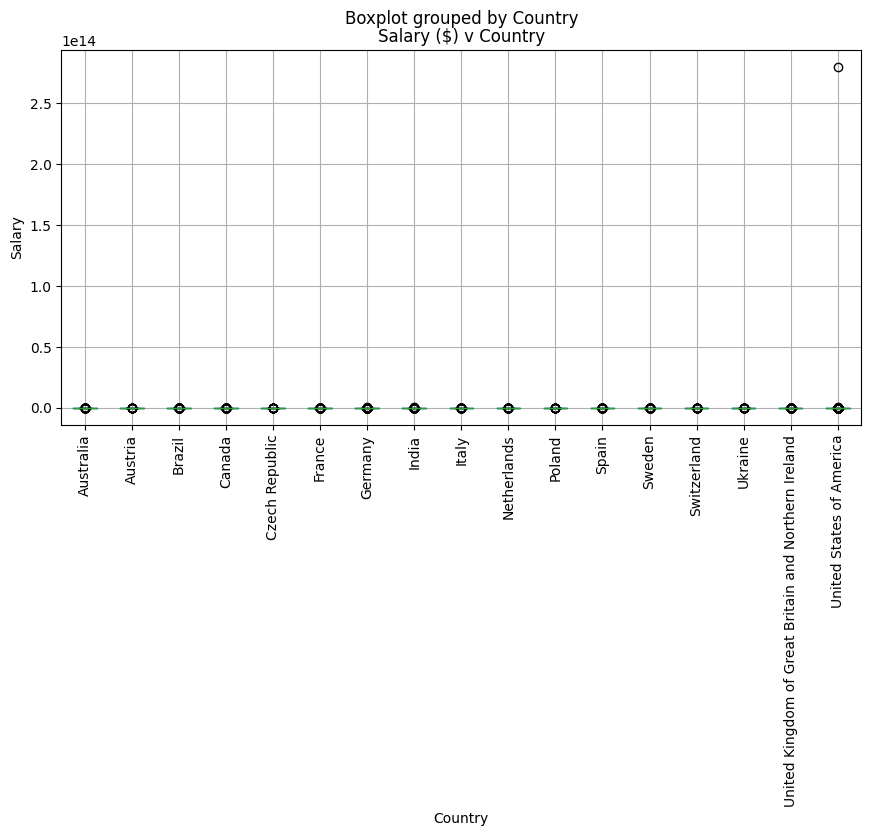

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
df.boxplot("CompTotalEUR", "Country", ax=ax)
plt.title("Salary ($) v Country")
plt.ylabel("Salary")
plt.xticks(rotation=90)
plt.show()

In [22]:
# There are some big outliers. I am going to cut them, so that the model
# gets less confused during training
df = df[df["CompTotalEUR"] <= 250000]
df = df[df["CompTotalEUR"] >= 10000]

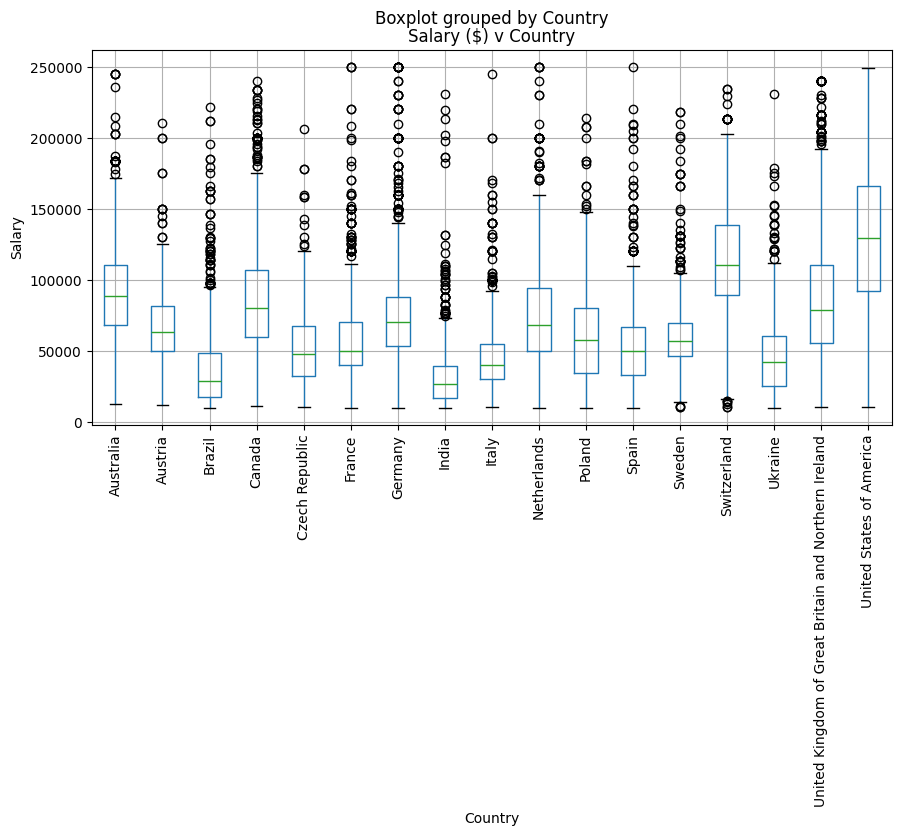

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
df.boxplot("CompTotalEUR", "Country", ax=ax)
plt.title("Salary ($) v Country")
plt.ylabel("Salary")
plt.xticks(rotation=90)
plt.show()

### Split the Data

It was necessary to clean some of the data before doing the split. Converting the currency is necessary to have equivalent target values to train and test on.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Generate train and test indices based on stratification
for train_index, test_index in splitter.split(df, df["Country"]):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

Since country logically should strongly influence the amount of money one earns It is necessary to clean the data before splitting. There are too many countries with too little entries to gain good training data. So the categories with too little entries were combined into the "Other" category. With this arrangement the split can be stratified by country. This allows a more even split for training and testing.

## Preprocessing



Does your data contain

    the correlations of interest?
    redundant information?
    missing / bad information?

In [25]:
train_df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,JobSat,CompTotalEUR
27645,27646,"I am not primarily a developer, but I write co...",35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Apples,Contribute to open-source projects;Other (plea...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",On the job training;Other online resources (e....,Technical documentation;Stack Overflow;Coding ...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Neither easy nor difficult,NaN,43943.005921
9120,9121,I am a developer by profession,35-44 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Apples,Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Blogs;Stack Overflow;C...,...,5.0,20.0,30.0,30.0,0.0,0.0,Appropriate in length,Easy,7.0,143187.066975
43140,43141,I am a developer by profession,45-54 years old,"Employed, full-time;Independent contractor, fr...","Hybrid (some remote, some in-person)",Apples,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",On the job training;Other online resources (e....,Blogs;Books;Written Tutorials;Coding sessions ...,...,75.0,0.0,0.0,5.0,5.0,0.0,Appropriate in length,Neither easy nor difficult,1.0,193995.381062
28932,28933,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","School (i.e., University, College, etc)",NaN,...,25.0,25.0,50.0,0.0,0.0,0.0,Appropriate in length,Neither easy nor difficult,7.0,62800.000000
52336,52337,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,I don’t code outside of work,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Colleague;On the job training;Other online res...,Technical documentation;Blogs;Written Tutorial...,...,50.0,30.0,10.0,0.0,0.0,0.0,Appropriate in length,Neither easy nor difficult,4.0,60000.000000


In [26]:

def assess_missing_values(data):
    """
    Returns a pandas dataframe denoting the total number of missing values and the percentage of missing values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()  # instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of missing values', 'Percent of missing values'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [27]:
df_NA = assess_missing_values(train_df)
df_NA

,Number of missing values,Percent of missing values
AINextMuch less integrated,17714,98.92
AINextLess integrated,17480,97.61
AINextMuch more integrated,14142,78.97
AINextNo change,14052,78.47
EmbeddedAdmired,12940,72.26
EmbeddedWantToWorkWith,12740,71.14
EmbeddedHaveWorkedWith,11546,64.47
AINextMore integrated,10337,57.72
AIToolNot interested in Using,10159,56.73
MiscTechAdmired,8629,48.19


In [ ]:
# Drop all features with more than 45% missing values
# Loop is necessary because the notebook crashes with a one line command. It seems to use much memory.
for col in train_df.columns:
    if train_df[col].isnull().mean() > 0.35:
        train_df.drop(columns=[col], inplace=True)

In [29]:
train_df.shape

(17908, 88)

In [30]:
df_NA = assess_missing_values(train_df)
df_NA

,Number of missing values,Percent of missing values
Knowledge_7,6260,34.96
Knowledge_8,6250,34.90
Knowledge_6,6225,34.76
Knowledge_5,6220,34.73
Frustration,6191,34.57
Knowledge_4,6178,34.50
Knowledge_2,6176,34.49
Frequency_1,6170,34.45
ProfessionalCloud,6167,34.44
Frequency_2,6165,34.43


Looking at both the different features and the amount of missing values a large number of features can be discarded right away.
The survey asked a lot of questions about personal preferences and opinions. These are irrelevant for a salary prediction model.

In [31]:
train_df = train_df[[ "CompTotalEUR", "Country", "EdLevel", "YearsCodePro", "Employment", 
                       "OrgSize", "LanguageHaveWorkedWith",  "DevType", "Industry", "WorkExp"]]

I have reduced the features to the ones that seemed relevant to the model. Columns like "Industry" might be relevant for the model as well but wiht over 50 percent of the rows values missing, Imputing those would only skew the training with and unintended bias, based in the imputation technique. So those can be removed as well.

In [32]:
train_df.head()

,CompTotalEUR,Country,EdLevel,YearsCodePro,Employment,OrgSize,LanguageHaveWorkedWith,DevType,Industry,WorkExp
27645,43943.005921,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,"Employed, full-time","1,000 to 4,999 employees",Groovy;Python;SQL,Cloud infrastructure engineer,NaN,NaN
9120,143187.066975,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,"Employed, full-time","10,000 or more employees",Bash/Shell (all shells);C#;Java;Kotlin;Python;SQL,"Developer, mobile",Other:,6.0
43140,193995.381062,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",29,"Employed, full-time;Independent contractor, fr...",100 to 499 employees,Bash/Shell (all shells);C;C++;Java;Objective-C...,Database administrator,Software Development,30.0
28932,62800.000000,Spain,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,"Employed, full-time","5,000 to 9,999 employees",C#,"Developer, full-stack",Manufacturing,20.0
52336,60000.000000,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",13,"Employed, full-time",20 to 99 employees,Bash/Shell (all shells);Java;Python;SQL,"Developer, back-end",Software Development,13.0


### Clean Years of Coding Professionally

In [33]:
train_df["YearsCodePro"].unique()

array(['15', '6', '29', '14', '13', '10', '8', '4', '3', '23', '5', '20',
       '2', '25', '11', '19', '16', '7', '30', '12', '31', '1', '9', '21',
       '27', 'Less than 1 year', '22', '38', '32', '28', '35', '40', '18',
       '24', '33', '36', nan, '17', '26', '42', '37', '45', '43', '34',
       '39', 'More than 50 years', '48', '44', '46', '47', '41', '50',
       '49'], dtype=object)

In [34]:
# remove the string
def clean_yearsCodePro(x):
    if x == "Less than 1 year":
        return 0
    if x == "More than 50 years":
        return 51
    return float(x)

train_df["YearsCodePro"] = train_df["YearsCodePro"].apply(clean_yearsCodePro)

In [35]:
train_df["YearsCodePro"].unique()

array([15.,  6., 29., 14., 13., 10.,  8.,  4.,  3., 23.,  5., 20.,  2.,
       25., 11., 19., 16.,  7., 30., 12., 31.,  1.,  9., 21., 27.,  0.,
       22., 38., 32., 28., 35., 40., 18., 24., 33., 36., nan, 17., 26.,
       42., 37., 45., 43., 34., 39., 51., 48., 44., 46., 47., 41., 50.,
       49.])

### Clean EducationLevel

In [36]:
train_df["EdLevel"].unique()

array(['Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else', 'Primary/elementary school'], dtype=object)

In [37]:
def group_education_levels(x):
    if "Bachelor’s degree" in x:
        return "Bachelor's degree"
    if "Master’s degree" in x:
        return "Master's degree"
    if "Professional degree" in x:
        return "Post grad"
    return "Less than a Bachelors"

train_df['EdLevel'] = train_df['EdLevel'].apply(group_education_levels)

In [38]:
train_df["EdLevel"].unique()

array(["Master's degree", "Bachelor's degree", 'Less than a Bachelors',
       'Post grad'], dtype=object)

### Clean Employment

For this model only full time employment is relevant. Since part time work can range drastically in working hours and students don't necessarily earn something, they aren't a reliable source of information.

In [39]:
train_df["Employment"].unique()

array(['Employed, full-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed',
       'Independent contractor, freelancer, or self-employed',
       'Employed, part-time', 'Student, part-time;Employed, part-time',
       'Employed, full-time;Student, full-time',
       'Student, full-time;Employed, part-time',
       'Employed, full-time;Student, part-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed;Student, part-time',
       'Student, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Student, full-time;Not employed, but looking for work;Independent contractor, freelancer, or self-employed',
       'Employed, full-time;Student, full-time;Employed, part-time',
       'Independent contractor, freelancer, or self-employed;Student, part-time',
       'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time',
       'Not employed, but look

In [40]:
train_df = train_df[train_df["Employment"] == "Employed, full-time"]

In [41]:
train_df = train_df.drop(columns="Employment")

In [42]:
train_df.shape

(13924, 9)

### Clean Org Size

In [43]:
train_df["OrgSize"].unique()

array(['1,000 to 4,999 employees', '10,000 or more employees',
       '5,000 to 9,999 employees', '20 to 99 employees',
       '100 to 499 employees', '2 to 9 employees', '10 to 19 employees',
       '500 to 999 employees',
       'Just me - I am a freelancer, sole proprietor, etc.',
       'I don’t know', nan], dtype=object)

In [44]:
train_df["OrgSize"].isna().sum()

np.int64(16)

In [45]:
from sklearn.impute import KNNImputer

In [46]:
# Define an ordered list of categories from smallest to largest
org_size_order = [
    'Just me - I am a freelancer, sole proprietor, etc.',
    '2 to 9 employees',
    '10 to 19 employees',
    '20 to 99 employees',
    '100 to 499 employees',
    '500 to 999 employees',
    '1,000 to 4,999 employees',
    '5,000 to 9,999 employees',
    '10,000 or more employees',
]

In [47]:
# Replace 'I don’t know' with NaN for imputation
train_df['OrgSize'] = train_df['OrgSize'].replace("I don’t know", np.nan)

### Clean DevType

In [48]:
train_df["DevType"].unique()

array(['Cloud infrastructure engineer', 'Developer, mobile',
       'Developer, full-stack', 'Developer, back-end',
       'Engineering manager', 'Developer, front-end',
       'Developer, desktop or enterprise applications',
       'Developer, QA or test', 'Blockchain', 'Other (please specify):',
       'Senior Executive (C-Suite, VP, etc.)', 'DevOps specialist',
       'Data engineer', 'Research & Development role',
       'Security professional', 'Developer, AI',
       'Developer, embedded applications or devices',
       'Academic researcher',
       'Data scientist or machine learning specialist',
       'Developer Advocate', 'System administrator',
       'Engineer, site reliability', 'Scientist',
       'Database administrator', 'Project manager', 'Product manager',
       'Developer Experience', 'Developer, game or graphics',
       'Data or business analyst', 'Educator', 'Designer',
       'Hardware Engineer', nan, 'Marketing or sales professional',
       'Student'], dtype=o

In [49]:
devtype_mapping = {
    'Developer, full-stack': 'Software Developer',
    'Developer, back-end': 'Software Developer',
    'Developer, front-end': 'Software Developer',
    'Developer, mobile': 'Software Developer',
    'Developer, desktop or enterprise applications': 'Software Developer',
    'Developer, embedded applications or devices': 'Software Developer',
    'Developer, game or graphics': 'Software Developer',
    'Developer, AI': 'Software Developer',
    'Developer, QA or test': 'Software Developer',
    'Developer Advocate': 'Software Developer',
    'Developer Experience': 'Software Developer',
    
    'Engineering manager': 'Manager',
    'Project manager': 'Manager',
    'Product manager': 'Manager',
    
    'Security professional': 'Software Engineer',
    'Cloud infrastructure engineer': 'Software Engineer',
    'Engineer, site reliability': 'Software Engineer',
    'Hardware Engineer': 'Software Engineer',
    
    'Data engineer': 'Data Specialist',
    'Data scientist or machine learning specialist': 'Data Specialist',
    'Data or business analyst': 'Data Specialist',
    
    'Academic researcher': 'Research & Academic',
    'Research & Development role': 'Research & Academic',
    'Educator': 'Research & Academic',
    'Scientist': 'Research & Academic',
    'Student': 'Research & Academic',
    
    'System administrator': 'Administrator',
    'Database administrator': 'Administrator',
    
    'Senior Executive (C-Suite, VP, etc.)': 'Executive',
    
    'Designer': 'Other',
    'Blockchain': 'Other',
    'Other (please specify):': 'Other',
    'Marketing or sales professional': 'Other',
}

In [50]:
train_df["DevType"] = train_df['DevType'].map(devtype_mapping)

### Clean Programming Languages

In [51]:
train_df["LanguageHaveWorkedWith"].unique()

array(['Groovy;Python;SQL',
       'Bash/Shell (all shells);C#;Java;Kotlin;Python;SQL', 'C#', ...,
       'GDScript;Go;Kotlin;Python;Rust;TypeScript',
       'Bash/Shell (all shells);C#;HTML/CSS;JavaScript;Python;Rust;TypeScript',
       'OCaml'], dtype=object)

Since there is a big correlation between the Developer Type and the programming language that is being used, this feature will be dropped.
Mainly with the user experience in mind. Because the user is thinking about going into this field of work, he probably doesn't have a concrete idea of what language he wants to use. That is ignoring the fact, that that also strongly depends on the specific job posting.
So this feature might overwhelm the user, with the large array of different programming languages, he's proabably never even heard of.

In [50]:
train_df = train_df.drop(columns="LanguageHaveWorkedWith")

### Clean Industry

In [51]:
train_df["Industry"].unique()

array([nan, 'Other:', 'Manufacturing', 'Software Development', 'Energy',
       'Banking/Financial Services', 'Healthcare',
       'Retail and Consumer Services', 'Transportation, or Supply Chain',
       'Computer Systems Design and Services', 'Insurance', 'Fintech',
       'Higher Education', 'Internet, Telecomm or Information Services',
       'Media & Advertising Services', 'Government'], dtype=object)

In [52]:
train_df["Industry"].isna().sum()

np.int64(4391)

In [53]:
train_df["Industry"].value_counts()

Industry
Software Development                          3389
Other:                                        1185
Internet, Telecomm or Information Services     528
Fintech                                        517
Healthcare                                     508
Manufacturing                                  501
Retail and Consumer Services                   467
Banking/Financial Services                     459
Government                                     368
Transportation, or Supply Chain                336
Media & Advertising Services                   318
Higher Education                               311
Computer Systems Design and Services           265
Energy                                         228
Insurance                                      153
Name: count, dtype: int64

In [54]:
train_df["Industry"] = train_df["Industry"].replace("Other:", np.nan)

## Model Selection, Training and Validation

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 27645 to 18319
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CompTotalEUR  13924 non-null  float64
 1   Country       13924 non-null  object 
 2   EdLevel       13924 non-null  object 
 3   YearsCodePro  13885 non-null  float64
 4   OrgSize       13729 non-null  object 
 5   DevType       13607 non-null  object 
 6   Industry      8348 non-null   object 
 7   WorkExp       9715 non-null   float64
dtypes: float64(3), object(5)
memory usage: 979.0+ KB


In [57]:
numerical_features = ["YearsCodePro", "WorkExp"]
categorical_features = ["Country", "EdLevel", "OrgSize", "DevType", "Industry"]

In [58]:


preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", KNNImputer(n_neighbors=3)),             # Impute missing values
            ("scaler", StandardScaler())                        # Scale numerical features
        ]), numerical_features),
        
        ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)

In [59]:
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [60]:
# Define model parameter grids

# Linear Regression model
param_grid_lr = {
    'preprocessor__num__imputer__n_neighbors': [3, 5, 7],            # KNN imputer neighbors
    'preprocessor__num__scaler': [StandardScaler(), None],            # Scaling choice (on/off)
    
    # Linear Regression specific parameters
    'regressor': [LinearRegression()],  # Model selector
    'regressor__fit_intercept': [True, False],
}

In [61]:
# Decision Tree Regressor model
param_grid_dtr = {
    'preprocessor__num__imputer__n_neighbors': [3, 5, 7],
    'preprocessor__num__scaler': [StandardScaler(), None],
    
    # Decision Tree Regressor specific parameters
    'regressor': [DecisionTreeRegressor()],  # Model selector
    'regressor__criterion': ['squared_error', 'friedman_mse'],  # Different criteria for split
    'regressor__splitter': ['best', 'random'],                  # Split strategy
    'regressor__max_depth': [5, 10, 20, 30],                 # Depth of tree
    'regressor__min_samples_split': [2, 5, 10],                 # Min samples for split
    'regressor__min_samples_leaf': [1, 2, 4]                    # Min samples per leaf
}

In [62]:
# Random Forest Regressor model
param_grid_rfr = {
    'preprocessor__num__imputer__n_neighbors': [3, 5, 7],
    'preprocessor__num__scaler': [StandardScaler(), None],
    
    # Random Forest Regressor specific parameters
    'regressor': [RandomForestRegressor()],  # Model selector
    'regressor__n_estimators': [50, 100, 200],                # Number of trees
    'regressor__max_depth': [5, 10, 20, 30],               # Depth of trees
    'regressor__min_samples_split': [2, 5, 10],               # Min samples for split
    'regressor__min_samples_leaf': [1, 2, 4],                 # Min samples per leaf
    'regressor__bootstrap': [True, False]                     # Bootstrap sampling
}


In [63]:
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),   # Preprocessing step
    ("regressor", LinearRegression())  # Regression model
])

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 27645 to 18319
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CompTotalEUR  13924 non-null  float64
 1   Country       13924 non-null  object 
 2   EdLevel       13924 non-null  object 
 3   YearsCodePro  13885 non-null  float64
 4   OrgSize       13729 non-null  object 
 5   DevType       13607 non-null  object 
 6   Industry      8348 non-null   object 
 7   WorkExp       9715 non-null   float64
dtypes: float64(3), object(5)
memory usage: 979.0+ KB


In [65]:
X_train = train_df.drop("CompTotalEUR", axis=1)
y_train = train_df["CompTotalEUR"]

In [66]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Set up GridSearchCV with the pipeline
grid_search_lr = GridSearchCV(model_pipeline, param_grid_lr, cv=5, scoring='neg_root_mean_squared_error')
grid_search_dtr = GridSearchCV(model_pipeline, param_grid_dtr, cv=5, scoring='neg_root_mean_squared_error')
grid_search_rfr = GridSearchCV(model_pipeline, param_grid_rfr, cv=5, scoring='neg_root_mean_squared_error')



In [353]:
# Fit the grid search
grid_search_lr.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search_lr.best_params_)
print("Best model:", grid_search_lr.best_estimator_)
print("Best cross-validated RMSE:", -grid_search_lr.best_score_)

Best parameters: {'preprocessor__num__imputer__n_neighbors': 5, 'preprocessor__num__scaler': None, 'regressor': LinearRegression(), 'regressor__fit_intercept': False}
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   None)]),
                                                  ['YearsCodePro', 'WorkExp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                 

In [354]:
# Fit the grid search
grid_search_dtr.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search_dtr.best_params_)
print("Best model:", grid_search_dtr.best_estimator_)
print("Best cross-validated RMSE:", -grid_search_dtr.best_score_)

c:\Users\Elena\.conda\envs\WageEstimator\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'preprocessor__num__imputer__n_neighbors': 7, 'preprocessor__num__scaler': StandardScaler(), 'regressor': DecisionTreeRegressor(), 'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__splitter': 'random'}
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsCodePro', 'WorkExp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                         

In [67]:
# Fit the grid search
grid_search_rfr.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search_rfr.best_params_)
print("Best model:", grid_search_rfr.best_estimator_)
print("Best cross-validated RMSE:", -grid_search_rfr.best_score_)

Best parameters: {'preprocessor__num__imputer__n_neighbors': 3, 'preprocessor__num__scaler': StandardScaler(), 'regressor': RandomForestRegressor(), 'regressor__bootstrap': True, 'regressor__max_depth': 20, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearsCodePro', 'WorkExp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                    

In [68]:
import pickle

In [69]:
# Save the entire best estimator (pipeline with preprocessor and model)
best_rfr_pipeline = grid_search_rfr.best_estimator_

with open("saved_rfr_pipeline.pkl", "wb") as file:
    pickle.dump(best_rfr_pipeline, file)

## Compare with Test Set

### Clean test set

In [70]:
test_df = test_df[[ "CompTotalEUR", "Country", "EdLevel", "YearsCodePro", "Employment", 
                       "OrgSize", "LanguageHaveWorkedWith",  "DevType", "Industry", "WorkExp"]]

In [71]:
test_df["YearsCodePro"] = test_df["YearsCodePro"].apply(clean_yearsCodePro)

In [72]:
test_df['EdLevel'] = test_df['EdLevel'].apply(group_education_levels)

In [74]:
test_df = test_df[test_df["Employment"] == "Employed, full-time"]
test_df = test_df.drop(columns="Employment")

In [76]:
test_df['OrgSize'] = test_df['OrgSize'].replace("I don’t know", np.nan)

In [78]:
test_df["DevType"] = test_df['DevType'].map(devtype_mapping)

In [79]:
test_df["DevType"] = test_df['DevType'].map(devtype_mapping)

In [80]:
test_df = test_df.drop(columns="LanguageHaveWorkedWith")

In [81]:
test_df["Industry"] = test_df["Industry"].replace("Other:", np.nan)

In [86]:
test_df["DevType"] = test_df["DevType"].replace(np.nan, 'Software Developer')

In [88]:
X_test = test_df.drop("CompTotalEUR", axis=1)
y_test = test_df["CompTotalEUR"]

### Compare performance

In [ ]:
y_pred = best_rfr_pipeline.predict(X_test)

error = np.sqrt(root_mean_squared_error(y_test, y_pred))

print("Root mean squared error: €{:,.02f}".format(error))